**Machine Learning for Time Series (Master MVA)**

- Tutorial 3, Friday 19<sup>th</sup> February 2021
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we illustrate the following concepts:

- signal prediction,
- model a signal in trend, seasonality and stationary process,
- the AR and MA processes,
- the singular spectrum analysis (SSA).

## Setup

**Imports**

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loadmydata.load_nyc_taxi import load_nyc_taxi_dataset
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster import hierarchy
from scipy.signal import argrelmax, periodogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

**Utility functions**

In [2]:
try:
    from numpy.lib.stride_tricks import (
        sliding_window_view,
    )  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]


except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )

In [3]:
def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

In [4]:
def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1
) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[
        all_local_max.argsort()[::-1]
    ][:n_largest]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [6]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [7]:
def average_anti_diag(traj_matrix: np.ndarray) -> np.ndarray:
    """Average anti diagonal elements of a 2d array"""
    x1d = [
        np.mean(traj_matrix[::-1, :].diagonal(i))
        for i in range(-traj_matrix.shape[0] + 1, traj_matrix.shape[1])
    ]
    return np.array(x1d)

## Data

In [8]:
X, _, description = load_nyc_taxi_dataset()
print(description)

This data set contains the number of New York taxi passengers aggregated in 30 minutes buckets for the period between July 2014 and January 2015. There are five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

The raw data is from the NYC Taxi and Limousine Commission [1] and has been curated by [2].

[1]: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 
[2]: Ahmad, S., Lavin, A., Purdy, S., & Agha, Z. (2017). Unsupervised real-time anomaly detection for streaming data. Neurocomputing.


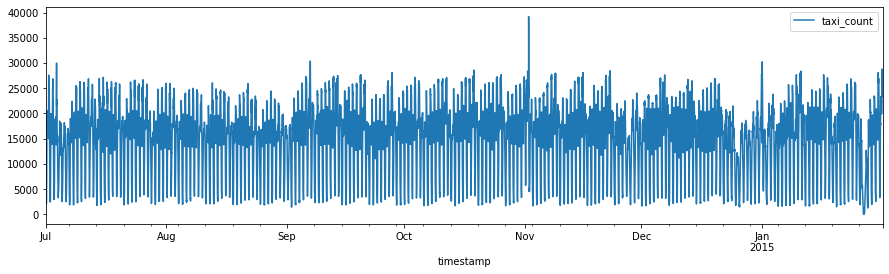

In [9]:
fig, ax = fig_ax()
_ = X.plot(x="timestamp", y="taxi_count", ax=ax)

We can also plot the taxi count for the month of October 2014.

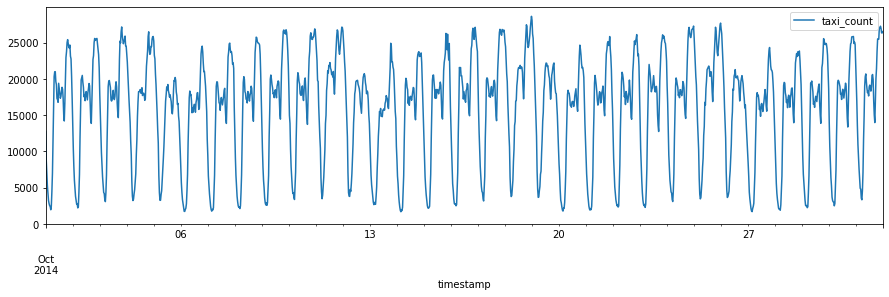

In [10]:
october_cond = X.timestamp.dt.month == 10

fig, ax = fig_ax()
X[october_cond].plot(x="timestamp", y="taxi_count", ax=ax)
_ = ax.set_ylim(0)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the taxi count for the 2014-10-12.</p>
</div>

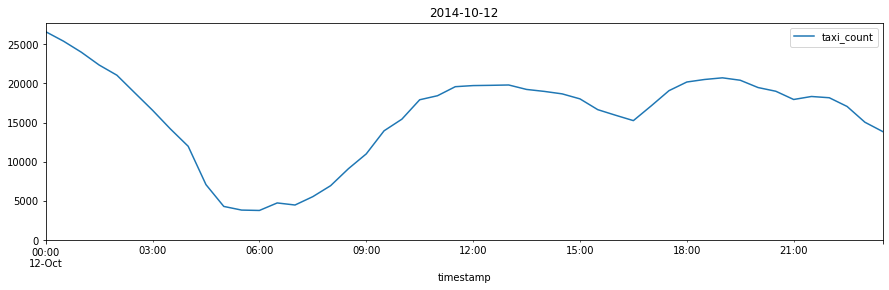

In [11]:
day = "2014-10-12"
day_cond = X.timestamp.dt.date == X.timestamp.dt.date[0].fromisoformat(day)

fig, ax = fig_ax()
plt.title(day)
X[day_cond].plot(x="timestamp", y="taxi_count", ax=ax)
_ = ax.set_ylim(0)

## Daily count

In this tutorial, we are interested in the evolution in the **daily** count.
To that end, we resample the original signal.

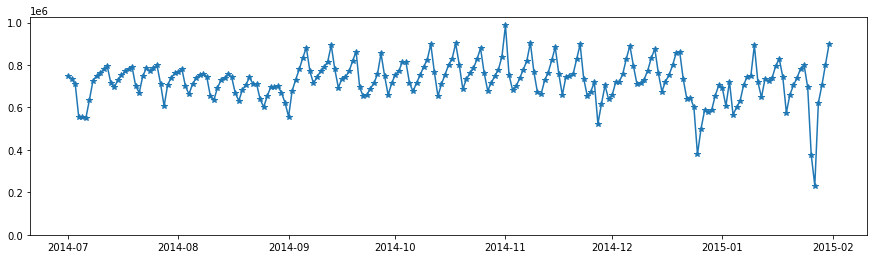

In [12]:
daily_taxi_count = X.resample("1D", on="timestamp").sum()
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the daily count in October 2014. What can you observe?</p>
</div>

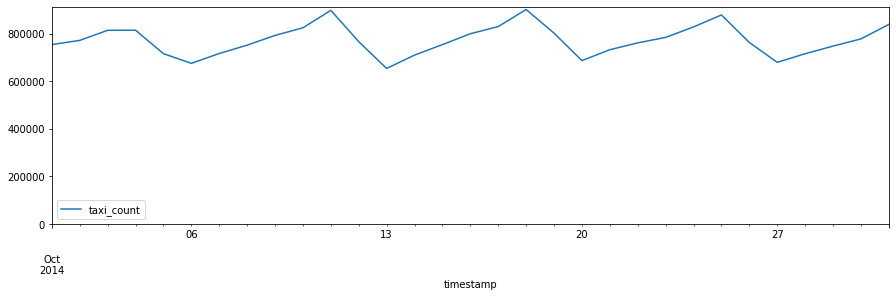

In [13]:
october_cond = daily_taxi_count.index.month == 10

fig, ax = fig_ax()
daily_taxi_count[october_cond].plot(ax=ax)
_ = ax.set_ylim(0)

We observe a periodicity of one week on the signal (which is not a real surprise). Moreover there is a peak each week (which is on Saturday as we will see).

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot or print the average count per day of the week. Which day is the busiest?</p>
</div>

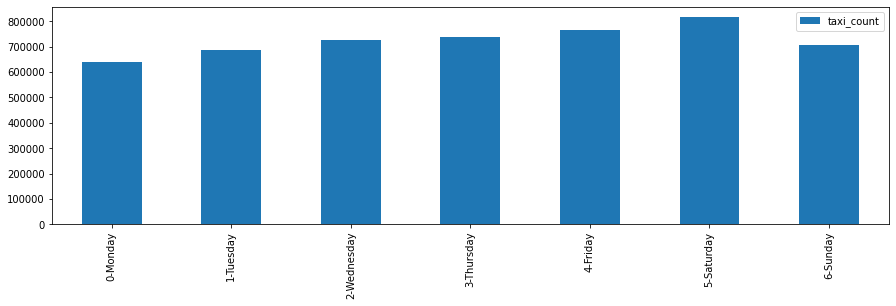

In [14]:
week_mean = daily_taxi_count.groupby(lambda date: f"{date.day_of_week}-{date.day_name()}").mean()

fig, ax = fig_ax()
week_mean.plot(kind="bar", ax=ax)
_ = ax.set_ylim(0)

Saturday is the busiest day.

# Signal Prediction

The objective is to predict the daily taxi for the next two weeks (14 days).
First, we prepare the training and testing data.

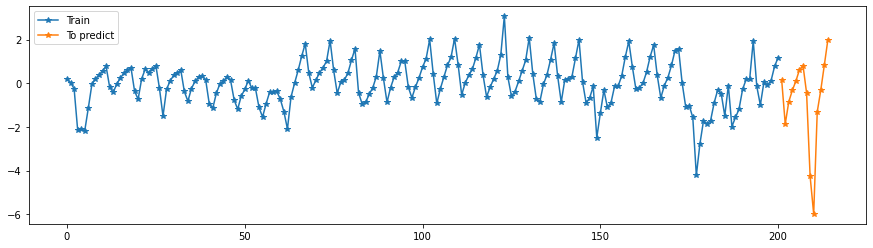

In [15]:
n_samples_pred = 14  # predict the next 14 samples

# train/test split
signal_train, signal_pred = np.split(
    daily_taxi_count_np.astype(float), [-n_samples_pred]
)
n_samples = n_samples_train = signal_train.size

# scaling
scaler = StandardScaler().fit(signal_train.reshape(-1, 1))
signal_train = scaler.transform(signal_train.reshape(-1, 1)).flatten()
signal_pred = scaler.transform(signal_pred.reshape(-1, 1)).flatten()

# keep the indexes of train and test (for plotting mostly)
time_array_train, time_array_pred = np.split(
    np.arange(daily_taxi_count_np.size), [-n_samples_pred]
)
time_array = time_array_train
calendar_time_array = daily_taxi_count.iloc[time_array].index.to_numpy()

# plot
fig, ax = fig_ax()
ax.plot(time_array_train, signal_train, "-*", label="Train")
ax.plot(time_array_pred, signal_pred, "-*", label="To predict")
_ = plt.legend()

## Trend

Three trend estimation methods are tested:

- constant trend,
- linear trend,
- polynomial trend.

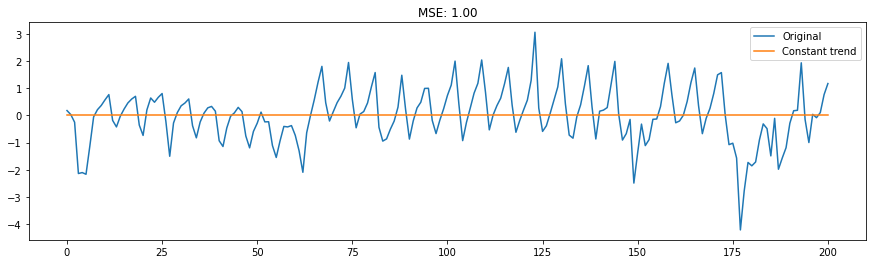

In [16]:
fig, ax = fig_ax()
ax.plot(signal_train, label="Original")

level = signal_train.mean()  # should be zero
approx_trend = level * np.ones(signal_train.size)
ax.plot(approx_trend, label="Constant trend")
ax.set_title(f"MSE: {(signal_train-approx_trend).var():.2f}")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the best linear approximation of the signal. What is the associated MSE?</p>
</div>

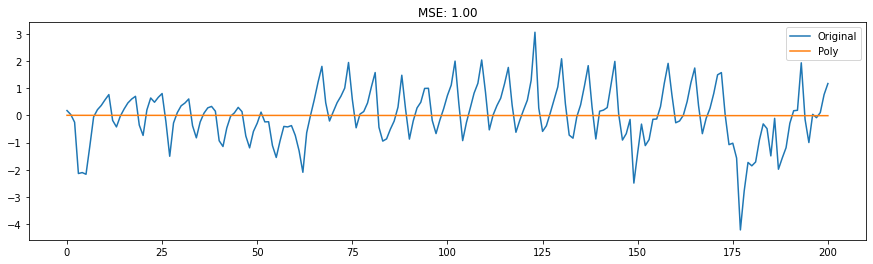

In [18]:
# Linear fitting
linear = Polynomial.fit(time_array, signal_train, deg=1)
approx_linear = linear(time_array)

# plot
fig, ax = fig_ax()
ax.plot(signal_train, label="Original")
ax.plot(approx_linear, label="Poly")
ax.set_title(f"MSE: {(signal_train-approx_linear).var():.2f}")

_ = plt.legend()

We can also try a polynomial trend.

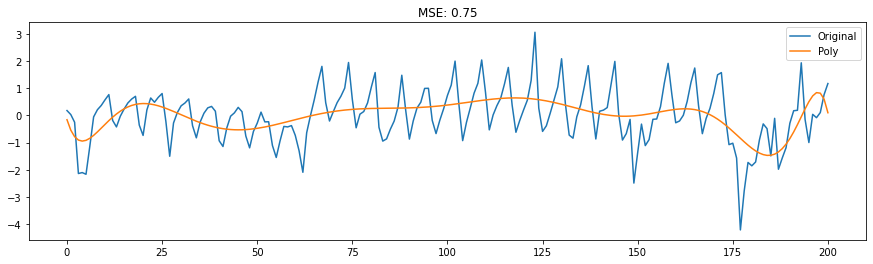

In [19]:
# polynomial fitting
poly = Polynomial.fit(time_array, signal_train, deg=13)
approx_poly = poly(time_array)

# plot
fig, ax = fig_ax()
ax.plot(signal_train, label="Original")
ax.plot(approx_poly, label="Poly")
ax.set_title(f"MSE: {(signal_train-approx_poly).var():.2f}")

_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous cell, show the trend predicted by the polynomial fit in the next 14 samples. What do you conclude?</p>
</div>

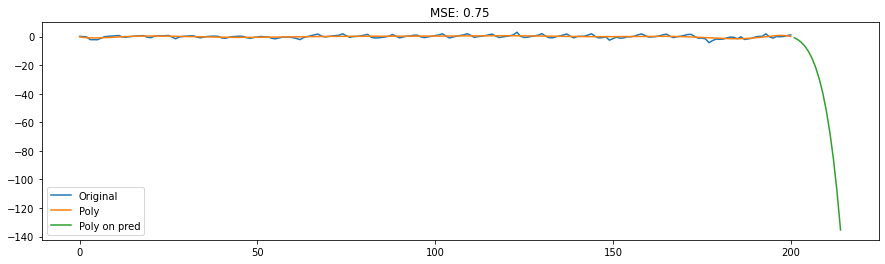

In [20]:
approx_poly_pred = poly(time_array_pred)

# plot
fig, ax = fig_ax()
ax.plot(time_array, signal_train, label="Original")
ax.plot(time_array, approx_poly, label="Poly")
ax.plot(time_array_pred, approx_poly_pred, label="Poly on pred")
ax.plot()
ax.set_title(f"MSE: {(signal_train-approx_poly).var():.2f}")

_ = plt.legend()

One can see that a polynomial fit explodes out of the time domain. It's totally expected as a polynom always explodes when the module of t is large. In fact polynom are not well designed to fit a signal and predict out of the domain which is what we want here. (It would have been better if we wanted to predict in-domain missing values for instance)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>To conclude, which trend do you choose?</p>
</div>

We can use the linear trend, even though if its coefficients are almost all equals to 0, it won't hurt us.

## Seasonality

The seasonality is the periodical component in the signal at hand.

**Finding the harmonic frequencies.**

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Give two ways to estimate the presence of seasonalities.</p>
</div>


We can use the autocorrelation and find maximums of lags. And we can also use Fourrier transforms.

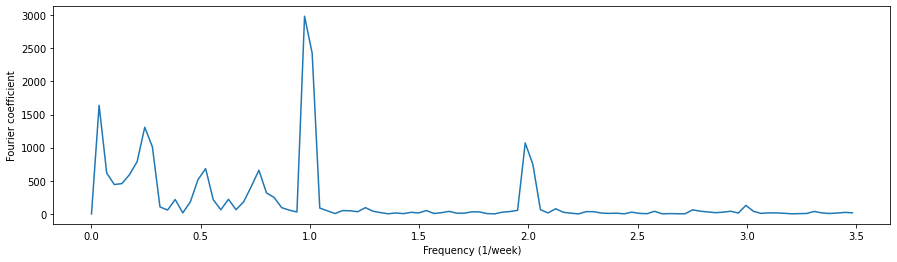

In [21]:
n_samples_per_week = 7

fourier = abs(rfft(signal_train)) ** 2
freqs = rfftfreq(n=n_samples, d=1 / n_samples_per_week)

fig, ax = fig_ax()
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (1/week)")
_ = ax.set_ylabel("Fourier coefficient")

The DFT is not a consistent estimator of the power spectral density.
In practice, the periodogram (or any other variations) is prefered: the DTF is computed over several (possibly overlapping) windows and averaged.

The main periods are 7.0 days and 224.0 days.


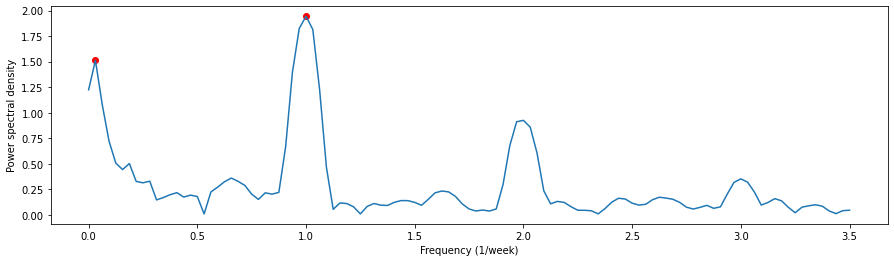

In [22]:
n_samples_per_week = 7

# compute the periodogram
freqs, Pxx_spec = periodogram(
    x=signal_train,
    fs=n_samples_per_week,
    window="flattop",
    nfft=32 * n_samples_per_week,
)
spectral_density = np.sqrt(Pxx_spec)

# find the main frequencies
values, (f_1_ind, f_2_ind) = get_largest_local_max(
    spectral_density, n_largest=2
)
(f_1, f_2) = np.take(freqs, (f_1_ind, f_2_ind))
print(
    f"The main periods are {7/f_1:.1f} day{'s' if 7/f_1>1 else ''} and {7/f_2:.1f} day{'s' if 7/f_2>1 else ''}."
)

# plotting
fig, ax = fig_ax()
ax.plot(freqs, spectral_density)
ax.scatter([f_1, f_2], values, color="r")
ax.set_xlabel("Frequency (1/week)")
_ = ax.set_ylabel("Power spectral density")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Modify the code above to estimate the main seasonality from the <b>original</b> signal. What do you conclude?</p>
</div>


The main periods are 1.0 day and 0.5 day.


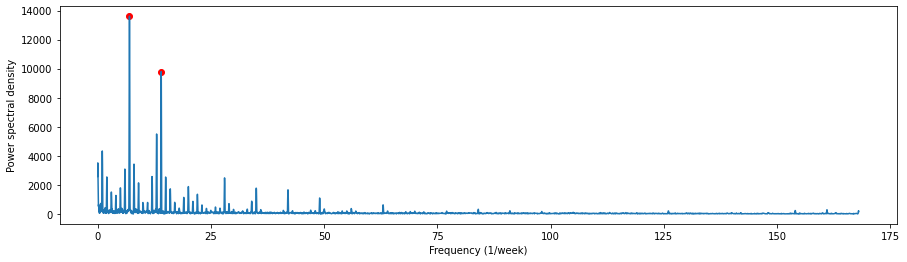

In [23]:
n_samples_per_week = 7 * 48

# compute the periodogram
freqs, Pxx_spec = periodogram(
    x=X.taxi_count.to_numpy(),
    fs=n_samples_per_week,
    window="flattop",
    nfft= 64 * n_samples_per_week,
)
spectral_density = np.sqrt(Pxx_spec)

# find the main frequencies
values, (f_1_ind, f_2_ind) = get_largest_local_max(
    spectral_density, n_largest=2
)
(f_1_, f_2_) = np.take(freqs, (f_1_ind, f_2_ind))
print(
    f"The main periods are {7/f_1_:.1f} day{'s' if 7/f_1_>1 else ''} and {7/f_2_:.1f} day{'s' if 7/f_2_>1 else ''}."
)

# plotting
fig, ax = fig_ax()
ax.plot(freqs, spectral_density)
ax.scatter([f_1_, f_2_], values, color="r")
ax.set_xlabel("Frequency (1/week)")
_ = ax.set_ylabel("Power spectral density")

**Harmonic regression**

In an harmonic regression (with two harmonic components), the signal is modelled as follows:
$$
y_t = \mu + A_1\cos(2\pi f_1 t + \phi_1) + A_2\cos(2\pi f_2 t + \phi_2) + \epsilon_t
$$

where $\mu, A, \phi\in\mathbb{R}$ must be estimated, the frequencies $f_1$ and $f_2$ are given, and $\epsilon_t$ is a white noise.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How can you rewrite this problem as a linear regression problem?</p>
</div>

Using that $\cos(a + b) = \cos(a)\cos(b) - \sin(a)\sin(b)$ we can rewrite $y_t$:

$$y_t = \mu + A_1\left[\cos(2\pi f_1 t)\cos(\phi_1) - \sin(2\pi f_1 t)\sin(\phi_1)\right] + A_2\left[\cos(2\pi f_2 t)\cos(\phi_2) - \sin(2\pi f_2 t)\sin(\phi_2)\right] + \epsilon_t$$

$$y_t = \mu + \begin{pmatrix} A_1 \cos(\phi_1)\\ -A_1 \sin(\phi_1) \\ A_2 \cos(\phi_2) \\ A_2 \sin(\phi_2)\end{pmatrix} \cdot \begin{pmatrix} \cos(2\pi f_1 t)\\ \sin(2\pi f_1 t) \\ \cos(2\pi f_2 t) \\ \sin(2\pi f_2 t)\end{pmatrix} + \epsilon_t$$


Which is a linear regression problem given all the cos and sin of $2f_it$



<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Code the harmonic regression with the two previously estimated frequencies and show the final fit, the residual signal and the MSE.</p>
</div>


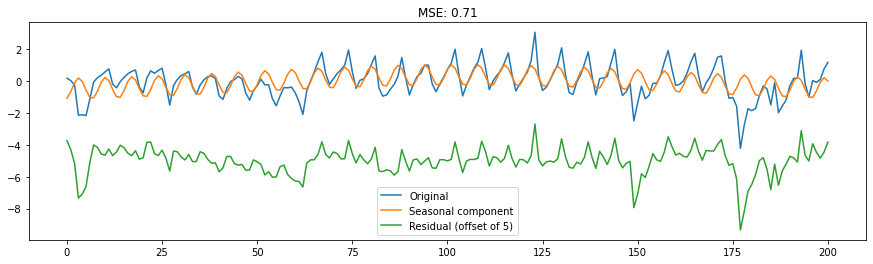

In [24]:
regressors = np.c_[
    np.cos(2 * np.pi * f_1 / 7 * time_array),
    np.sin(2 * np.pi * f_1 / 7 * time_array),
    np.cos(2 * np.pi * f_2 / 7 * time_array),
    np.sin(2 * np.pi * f_2 / 7 * time_array),
    np.ones(n_samples),
]

beta, residuals, *_ = np.linalg.lstsq(regressors, signal_train, rcond=None)

fig, ax = fig_ax()
ax.plot(signal_train, label="Original")
approx_seasonal = regressors @ beta
residual_signal = signal_train - approx_seasonal
ax.plot(approx_seasonal, label="Seasonal component")
ax.plot(residual_signal- 5, label="Residual (offset of 5)")
ax.set_title(f"MSE: {residuals[0]/n_samples:.2f}")
_ = plt.legend()

## Studying the residual signal

### A simulated example

Simulate a MA(2) process and an AR(2) process.
For each plot the autocorrelation and partial autocorrelation.

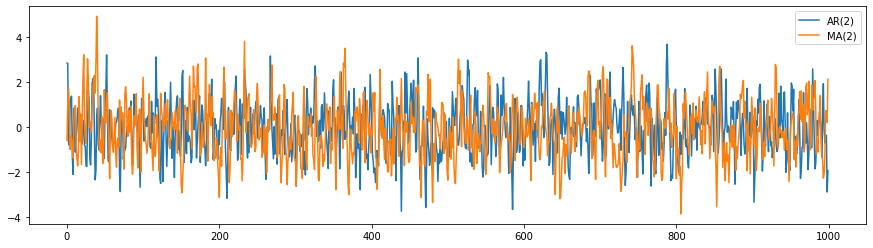

In [25]:
arparams = np.array([0.55, -0.25])
maparams = np.array([0.65, 0.35])

ar = np.r_[1, -arparams]  # add zero-lag and negate
ma = np.r_[1, maparams]  # add zero-lag


n_samples_simulated = 1000
ar2 = arma_generate_sample(ar, [1], n_samples_simulated)
ma2 = arma_generate_sample([1], ma, n_samples_simulated)

fig, ax = fig_ax()
ax.plot(ar2, label="AR(2)")
ax.plot(ma2, label="MA(2)")
_ = plt.legend()

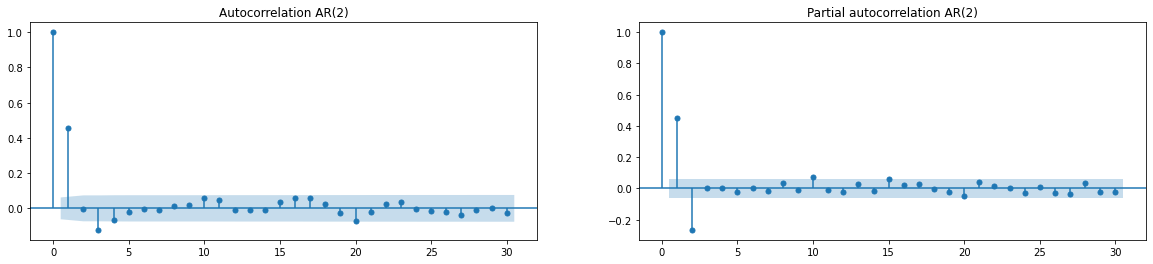

In [26]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ar2, ax=ax_0, title="Autocorrelation AR(2)")
_ = plot_pacf(ar2, ax=ax_1, title="Partial autocorrelation AR(2)")

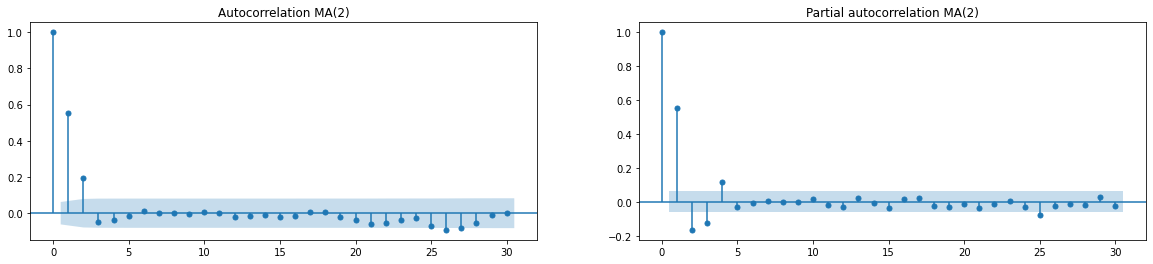

In [27]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ma2, ax=ax_0, title="Autocorrelation MA(2)")
_ = plot_pacf(ma2, ax=ax_1, title="Partial autocorrelation MA(2)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What would be a procedure to estimate the AR and MA order of a process?</p>
</div>

For the model AR we can read the last non-zero coefficient index of the partial autocorrelation.

For the model MA we can read the last non-zero coefficient index of the autocorrelation 

### Back to our problem

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the autocorrelation and partial autocorrelation of the residual signal (without the constant and harmonic trend).</p>
</div>

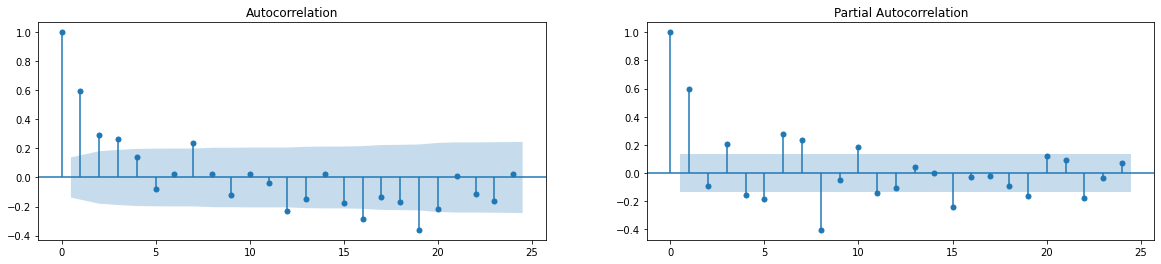

In [28]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(residual_signal, ax=ax_0)
_ = plot_pacf(residual_signal, ax=ax_1)

Now, we fit an ARMA process on the residual signal.

In [29]:
ma_order = 7
ar_order = 8

res = ARIMA(residual_signal, order=(ar_order, 0, ma_order)).fit()
print(res.summary())

/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:                 ARIMA(8, 0, 7)   Log Likelihood                -142.825
Date:                Tue, 23 Feb 2021   AIC                            319.650
Time:                        18:51:01   BIC                            375.806
Sample:                             0   HQIC                           342.374
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.052      0.122      0.903      -0.096       0.109
ar.L1          0.8020      0.105      7.669      0.000       0.597       1.007
ar.L2         -0.0105      0.102     -0.103      0.9

/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Using the fitted model, it is now possible to predict the value of the residual signal.

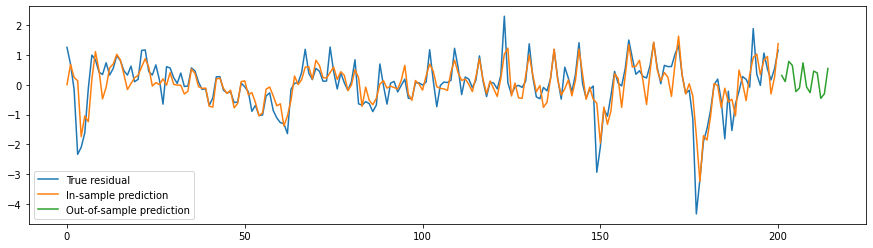

In [30]:
in_sample_pred = res.predict()
out_sample_pred = res.forecast(n_samples_pred)

fig, ax = fig_ax()
ax.plot(time_array_train, residual_signal, label="True residual")
ax.plot(time_array_train, in_sample_pred, label="In-sample prediction")
ax.plot(time_array_pred, out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

### Final prediction

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Make and plot the final prediction for the taxi count (not normalized) for the next two weeks, using the trend, seasonal and residual processes.</p>
    <p>What do you conclude?</p>
</div>

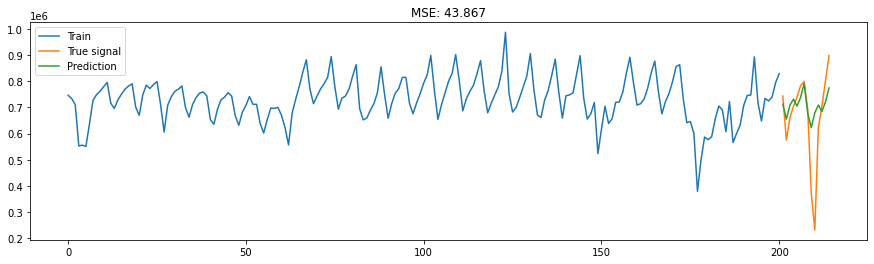

In [31]:
regressors_pred = np.c_[
    np.cos(2 * np.pi * f_1 / 7 * time_array_pred),
    np.sin(2 * np.pi * f_1 / 7 * time_array_pred),
    np.cos(2 * np.pi * f_2 / 7 * time_array_pred),
    np.sin(2 * np.pi * f_2 / 7 * time_array_pred),
    np.ones(n_samples_pred)
]

approx_seasonal_pred = regressors_pred @ beta

signal_predicted = out_sample_pred + approx_seasonal_pred

fig, ax = fig_ax()


plt.title(f"MSE: {np.sum((signal_predicted - signal_pred)**2):.3f}")
ax.plot(time_array, scaler.inverse_transform(signal_train), label="Train")
ax.plot(time_array_pred, scaler.inverse_transform(signal_pred), label="True signal")
ax.plot(time_array_pred, scaler.inverse_transform(signal_predicted), label="Prediction")

_ = plt.legend()

### Stationarity checks

As was previously seen, the residual signal was not completely stationary since it still contained seasonal and low frequency components.
To assess this intuition, several statistical tests exists. Two of the most well-known are:

- the Dickey-Fuller test (H0: the signal has a unit root); 
- the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (H0: the signal is trend/level stationary vs H1:the signal has a unit root).

Actually, they do not test for stationarity but for symptoms of non-stationarity.

In [32]:
adf_test(residual_signal)

Results of Dickey-Fuller Test:
Test Statistic                  -4.507044
p-value                          0.000191
#Lags Used                      14.000000
Number of Observations Used    186.000000
Critical Value (1%)             -3.466005
Critical Value (5%)             -2.877208
Critical Value (10%)            -2.575122
dtype: float64


In [33]:
kpss_test(residual_signal)

Results of KPSS Test:
Test Statistic           0.056352
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What can you conclude from the two tests?</p>
</div>

The p-value for the Didkey fuller is low enough so that we can reject H0 (signal has a unique root).

The p-value for the KPSS test is too large, we can't reject H0 (signal is trend/level stationnary).

Both tests seems to indicate that the residual signal can be considered has stationnary.

## Manage complex trend and outliers with SSA

With Singular Spectrum Analysis (SSA), it is possible to manage the low frequency trends and seasonnal effects with the same procedure.
SSA is often described as a "PCA for signals".

Let $y = \{y_t\}_t$ denote a $T$-sample long univariate signal, and $L$ a window length.
The trajectory matrix $X$ is formed by  $M$ lag-shifted copies of $y$, i.e.

$$
X:=
\begin{bmatrix}
y_1&y_2&y_3&\ldots&y_{L}\\
y_2&y_3&y_4&\ldots&y_{L+1}\\
y_3&y_4&y_5&\ldots&y_{L+2}\\
\vdots&\vdots&\vdots&\ddots&\vdots
\end{bmatrix}
$$


Now, write the Singular Value Decomposition (SVD) of $X$ is as follows:

$$
X = U\Sigma V^T = \sum_{i=1}^{L} X_i\quad\text{with}\quad X_i:= \sigma_i u_i v_i^T
$$

where $\sigma=\text{diag}(\sigma_1,\dots,\sigma_L)$ are the singular values sorted in descending order, $u_i$ and $v_i$ are respectively the associated left and right singular vectors corresponding to the columns of the orthogonal matrices $U$ and $V$.
Each $X_i$ is itself a trajectory matrix.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For a signal of length $T$ and a window of length $L$, what are the dimensions of the trajectory matrix (number of rows and columns)?</p>
</div>

It has T - L + 1 rows (the first one ends with $y_L$ and the last with $y_{T}$), and obviously L columns.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How can you go from a trajectory matrix to a signal?</p>
</div>

We can simply averaged of the matrix over its antidiagonal. (Or equivalently averaged the values we have for each timestamp)

Let us apply apply SSA on the signal.

In [34]:
window_shape = 14
trajectory_matrix = get_trajectory_matrix(signal_train, window_shape)

In [35]:
# SVD
u, eigenvals, vh = np.linalg.svd(trajectory_matrix, full_matrices=False)

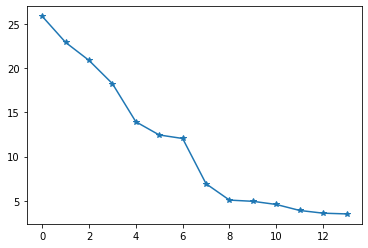

In [36]:
plt.plot(eigenvals, "-*")

In [37]:
ssa_decomposition = np.zeros((signal_train.size, window_shape))

for (ind, (left, sigma, right)) in enumerate(zip(u.T, eigenvals, vh)):
    ssa_decomposition.T[ind] = average_anti_diag(
        sigma * np.dot(left.reshape(-1, 1), right.reshape(1, -1))
    )

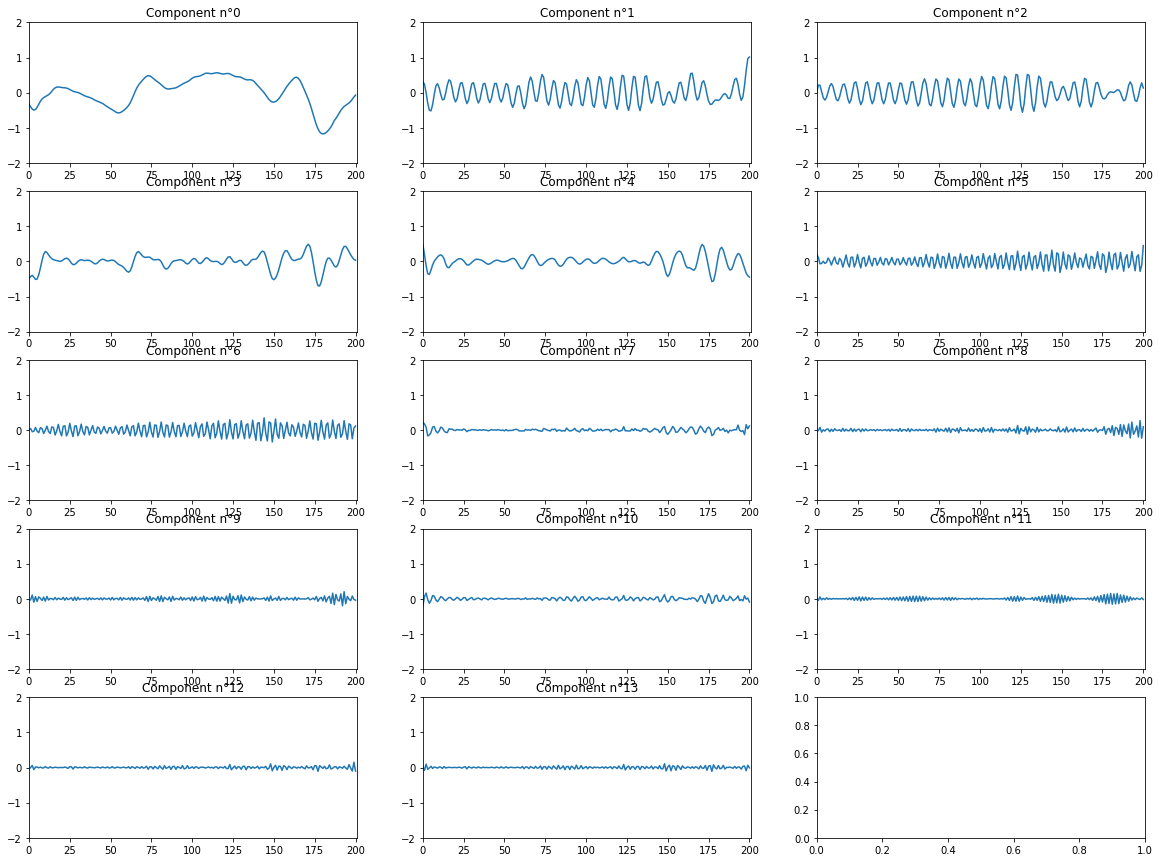

In [38]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)

for (ind, (component, ax)) in enumerate(
    zip(ssa_decomposition.T, ax_arr.flatten())
):
    ax.plot(component)
    ax.set_xlim(0, component.size)
    ax.set_ylim(-2, 2)
    ax.set_title(f"Component n°{ind}")

In pratice, the trend (a slowly varying component), the periodic components and noise are well separated by SSA.

We can plot the successive reconstructions when adding one SSA component at a time.

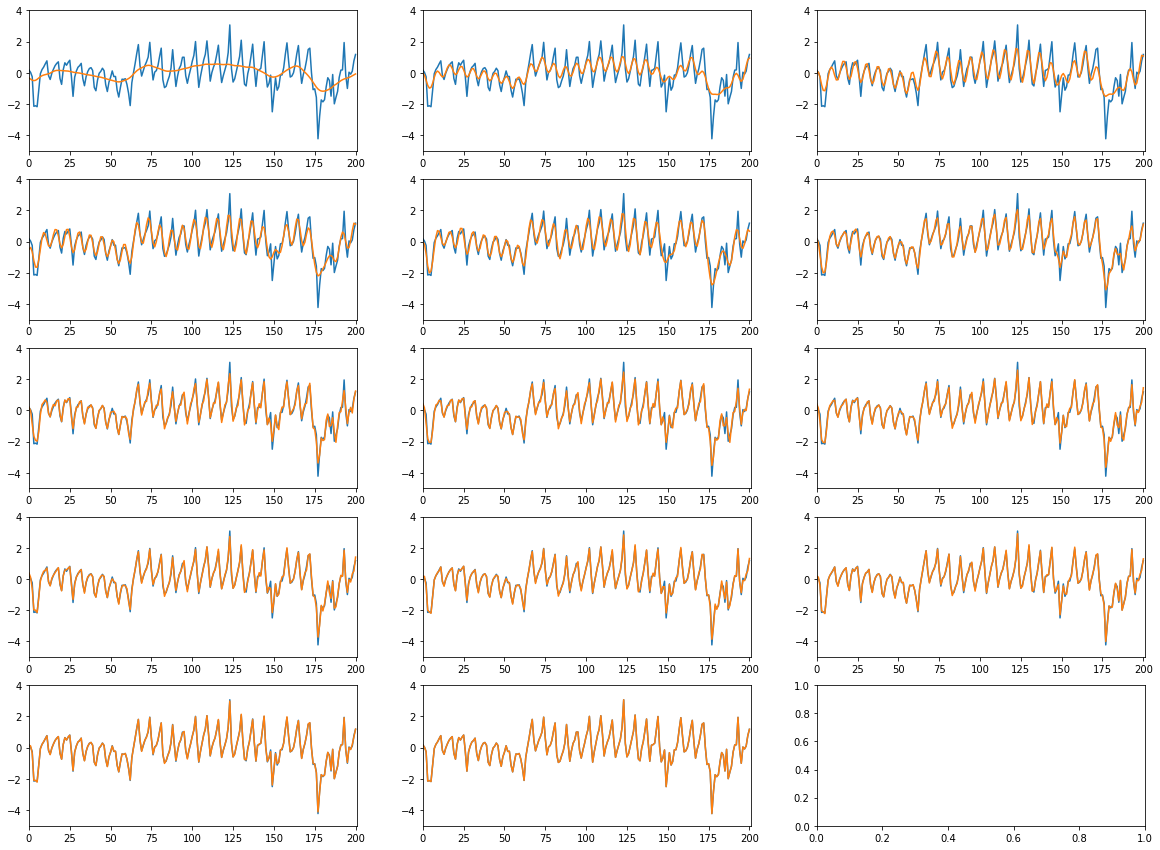

In [39]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)

reconstruction = np.zeros(signal_train.size)

for component, ax in zip(ssa_decomposition.T, ax_arr.flatten()):
    reconstruction += component
    ax.plot(signal_train)
    ax.plot(reconstruction)
    ax.set_xlim(0, reconstruction.size)
    ax.set_ylim(-5, 4)

**Grouping**

Notice that several SSA components are very similar.
Usually they are summed together to deacrease the dimension of the representation.
This operation is called "grouping".

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>As in the previous tutorial, use a hierarchical clustering approach to group the SSA components together. (use the Euclidean distance and plot the associated dendogram.)</p>
</div>

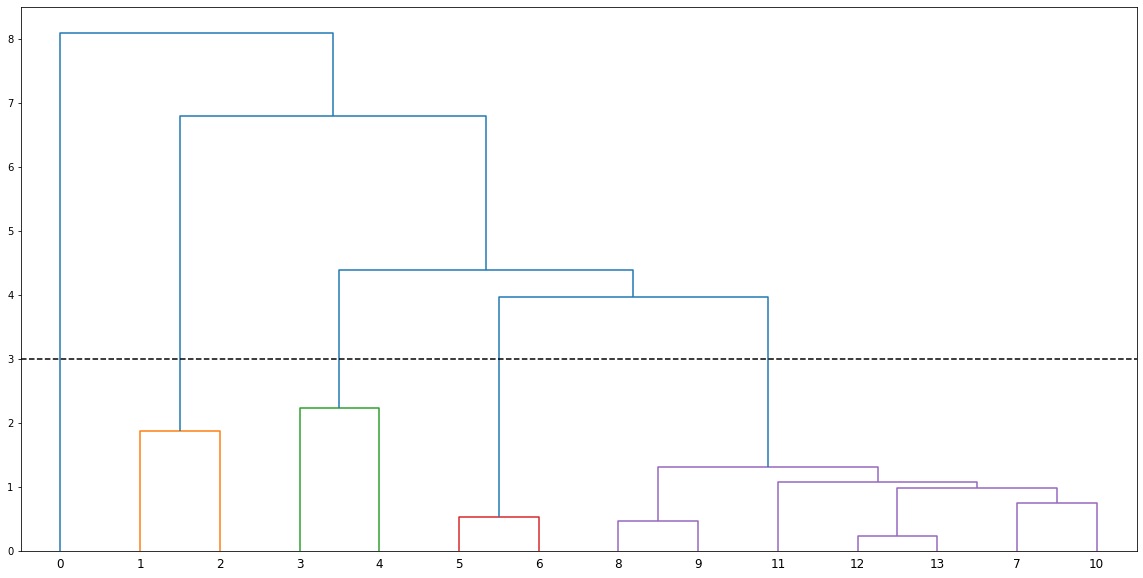

In [40]:
corr = pdist(ssa_decomposition.T)
corr_linkage = hierarchy.ward(corr)

fig, ax = fig_ax((20, 10))

cut_threshold = 3

dendro = hierarchy.dendrogram(
    corr_linkage,
    ax=ax,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Report the groups that you found in the <tt>groups</tt> variable.</p>
</div>

In [41]:
groups = [[0], [1, 2], [3, 4], [5, 6], [8, 9, 11, 12, 13, 7, 10]]

Let us plot each SSA group individually.

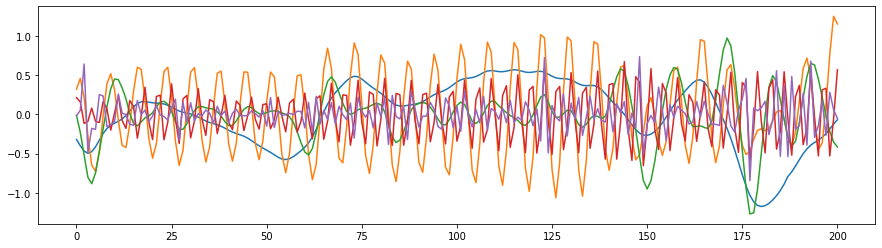

In [42]:
# grouping
grouped_ssa = np.zeros((signal_train.size, len(groups)))

for (dim_ind, component_indexes) in enumerate(groups):
    grouped_ssa.T[dim_ind] = np.take(
        ssa_decomposition, component_indexes, axis=-1
    ).sum(axis=1)

fig, ax = fig_ax()
_ = ax.plot(grouped_ssa)

**Prediction**

The SSA componant are then individually extrapolated by fitting an autoregressive model.
The extended component are summed to produce the forecast values.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Make and plot the final prediction for the taxi count (not normalized) for the next two weeks, by fitting an AR(8) process (use <tt>AutoReg(signal_train, lags=8)</tt>) to each SSA component and summing the forecasts.</p>
</div>

/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names t

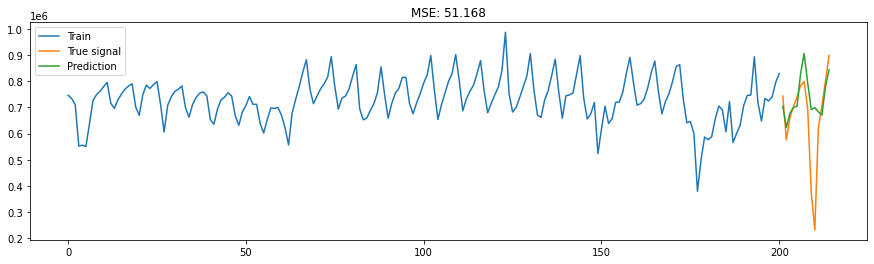

In [43]:
models = []

for ssa_component in grouped_ssa.T:
    models.append(AutoReg(ssa_component, lags=8).fit())

signal_predicted = np.zeros(n_samples_pred)
for model in models:
    signal_predicted += model.forecast(n_samples_pred)
    

fig, ax = fig_ax()

plt.title(f"MSE: {np.sum((signal_predicted - signal_pred)**2):.3f}")
ax.plot(time_array, scaler.inverse_transform(signal_train), label="Train")
ax.plot(time_array_pred, scaler.inverse_transform(signal_pred), label="True signal")
ax.plot(time_array_pred, scaler.inverse_transform(signal_predicted), label="Prediction")

_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Conclude. (Is it better or worse than the previous approach? What can we do to improve the results? What is the limitation?)</p>
</div>

It's worse than the previous approach. We should have may be filter some components, or use different ARMA models.

Both methods are unable to predict outliers!